<a href="https://colab.research.google.com/github/serjisa/BostonGene_education/blob/master/%D0%9A%D0%BE%D0%BB%D0%B8%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D0%BA%D1%80%D0%B8%D0%BF%D1%82%D0%BE%D0%BC%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://www.bostongene.com/wp-content/uploads/2019/04/br-website-logo_notm.png)

# Анализ результатов секвенирования РНК (bulk RNA-Seq)

## Подготовка данных — от прочтений до матрицы экспрессии

### Загрузка сырых прочтений из SRA

Данные по экспрессии хранятся в базе данных GEO. Выберем [один эксперимент](https://www.pnas.org/content/116/50/25287.long) с кишечной палочкой, в котором изучали адаптивную эволюцию в условиях оксидативного стресса ([GSE135867](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE135867)). Каждому эксперименту к GEO соответствует несколько датасетов в SRA (конкретный результат конкретного секвенирования). Для простоты выберем два условия (по две реплики):

*   Дикий тип ([SRR9972882](https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR9972882) и [SRR9972883](https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR9972883));
*   ∆ubiC ([SRR9972884](https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR9972884) и [SRR9972885](https://trace.ncbi.nlm.nih.gov/Traces/sra/?run=SRR9972885)).

Для того, чтобы загрузить данные из базы SRA, необходимо воспользоваться программой <code>fasterq-dump</code> из пакета <code>SRA Toolkit</code>.

In [0]:
!wget "http://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz"
!tar -xzf sratoolkit.current-centos_linux64.tar.gz

--2020-03-10 18:35:47--  http://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.12, 2607:f220:41e:250::7
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.12|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz [following]
--2020-03-10 18:35:53--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-centos_linux64.tar.gz
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94363852 (90M) [application/x-gzip]
Saving to: ‘sratoolkit.current-centos_linux64.tar.gz’

sratoolkit.current- 100%[===================>]  89.99M   125MB/s    in 0.7s    

2020-03-10 18:35:54 (125 MB/s) - ‘sratoolkit.current-c

In [0]:
!mkdir raw_data
!./sratoolkit.2.10.4-centos_linux64/bin/fasterq-dump SRR9972882 -O raw_data/SRR9972882
!./sratoolkit.2.10.4-centos_linux64/bin/fasterq-dump SRR9972883 -O raw_data/SRR9972883
!./sratoolkit.2.10.4-centos_linux64/bin/fasterq-dump SRR9972884 -O raw_data/SRR9972884
!./sratoolkit.2.10.4-centos_linux64/bin/fasterq-dump SRR9972885 -O raw_data/SRR9972885

spots read      : 12,764,528
reads read      : 25,529,056
reads written   : 25,529,056
spots read      : 13,578,580
reads read      : 27,157,160
reads written   : 27,157,160
spots read      : 10,604,620
reads read      : 21,209,240
reads written   : 21,209,240
spots read      : 10,808,529
reads read      : 21,617,058
reads written   : 21,617,058


In [0]:
!ls raw_data
!ls raw_data/SRR9972882

SRR9972882  SRR9972883	SRR9972884  SRR9972885
SRR9972882_1.fastq  SRR9972882_2.fastq


Теперь у нас есть 4 папки, в каждой из которых по два файла &mdash; прямые и обратные прочтения.

### Установка kallisto

Для того, чтобы откартировать имеющиеся прочтения на референс, воспользуемся программой [kallisto](https://pachterlab.github.io/kallisto/).

In [0]:
!git clone https://github.com/pachterlab/kallisto.git

Cloning into 'kallisto'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 3798 (delta 13), reused 19 (delta 12), pack-reused 3776
Receiving objects: 100% (3798/3798), 4.05 MiB | 20.54 MiB/s, done.
Resolving deltas: 100% (2465/2465), done.


In [0]:
!apt-get install autoconf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  automake autotools-dev libsigsegv2 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc libtool gettext m4-doc
The following NEW packages will be installed:
  autoconf automake autotools-dev libsigsegv2 m4
0 upgraded, 5 newly installed, 0 to remove and 25 not upgraded.
Need to get 1,082 kB of archives.
After this operation, 3,994 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsigsegv2 amd64 2.12-1 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 m4 amd64 1.4.18-1 [197 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 autoconf all 2.69-11 [322 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 autotools-dev all 20180224.1 [39.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/main amd64 automake all 1:1.15.1-3ubuntu2 [509 kB]
Fet

In [0]:
!cd kallisto && mkdir build && cd build && cmake .. && make

[  3%] Performing configure step for 'htslib'
checking for gcc... gcc
checking whether the C compiler works... yes
checking for C compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C compiler... yes
checking whether gcc accepts -g... yes
checking for gcc option to accept ISO C89... none needed
checking for ranlib... ranlib
checking for special C compiler options needed for large files... no
checking for _FILE_OFFSET_BITS value needed for large files... no
checking shared library type... plain .so
checking how to run the C preprocessor... gcc -E
checking for grep that handles long lines and -e... /bin/grep
checking for egrep... /bin/grep -E
checking for ANSI C header files... yes
checking for sys/types.h... yes
checking for sys/stat.h... yes
checking for stdlib.h... yes
checking for string.h... yes
checking for memory.h... yes
checki

In [0]:
!./kallisto/build/src/kallisto --help

Error: invalid command --help
kallisto 0.46.2

Usage: kallisto <CMD> [arguments] ..

Where <CMD> can be one of:

    index         Builds a kallisto index 
    quant         Runs the quantification algorithm 
    bus           Generate BUS files for single-cell data 
    pseudo        Runs the pseudoalignment step 
    merge         Merges several batch runs 
    h5dump        Converts HDF5-formatted results to plaintext
    inspect       Inspects and gives information about an index
    version       Prints version information
    cite          Prints citation information

Running kallisto <CMD> without arguments prints usage information for <CMD>



### Подготовка референска и квантификация

Программа kallisto &mdash; это псевдо-выравниватель (подробнее было на лекции), то есть для него необходим референсный <i>транскриптом</i>, на который он будет выравнивать. После его загрузки его необходимо будет проиндексировать. Например, его можно взять [тут](http://bacteria.ensembl.org/Escherichia_coli_str_k_12_substr_mg1655/Info/Index).

In [0]:
!wget ftp://ftp.ensemblgenomes.org/pub/bacteria/release-46/fasta/bacteria_0_collection/escherichia_coli_str_k_12_substr_mg1655/cds/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cds.all.fa.gz
!gunzip Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cds.all.fa.gz
!mkdir ref_transcriptome
!mv Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cds.all.fa ref_transcriptome/E_coli_K12_CDS.fa

--2020-03-10 19:35:05--  ftp://ftp.ensemblgenomes.org/pub/bacteria/release-46/fasta/bacteria_0_collection/escherichia_coli_str_k_12_substr_mg1655/cds/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cds.all.fa.gz
           => ‘Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cds.all.fa.gz’
Resolving ftp.ensemblgenomes.org (ftp.ensemblgenomes.org)... 193.62.197.75
Connecting to ftp.ensemblgenomes.org (ftp.ensemblgenomes.org)|193.62.197.75|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/bacteria/release-46/fasta/bacteria_0_collection/escherichia_coli_str_k_12_substr_mg1655/cds ... done.
==> SIZE Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cds.all.fa.gz ... 1460658
==> PASV ... done.    ==> RETR Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cds.all.fa.gz ... done.
Length: 1460658 (1.4M) (unauthoritative)

Escherichia_coli_st 100%[===================>]   1.39M  2.45MB/s    in 0.6s    

2020-03-

In [0]:
!head ref_transcriptome/E_coli_K12_CDS.fa

>AAC73112 cds chromosome:ASM584v2:Chromosome:190:255:1 gene:b0001 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:thrL description:thr operon leader peptide
ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCG
GGCTGA
>AAC73113 cds chromosome:ASM584v2:Chromosome:337:2799:1 gene:b0002 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:thrA description:Bifunctional aspartokinase/homoserine dehydrogenase 1
ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTT
GCCGATATTCTGGAAAGCAATGCCAGGCAGGGGCAGGTGGCCACCGTCCTCTCTGCCCCC
GCCAAAATCACCAACCACCTGGTGGCGATGATTGAAAAAACCATTAGCGGCCAGGATGCT
TTACCCAATATCAGCGATGCCGAACGTATTTTTGCCGAACTTTTGACGGGACTCGCCGCC
GCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAAACTTTCGTCGATCAGGAATTTGCCCAA
ATAAAACATGTCCTGCATGGCATTAGTTTGTTGGGGCAGTGCCCGGATAGCATCAACGCT


Для того, чтобы построить референсный граф де Брёйна для kallisto используется команда <code>kallisto index</code>.

In [0]:
!./kallisto/build/src/kallisto index -i ref_transcriptome/transcripts.idx ref_transcriptome/E_coli_K12_CDS.fa


[build] loading fasta file ref_transcriptome/E_coli_K12_CDS.fa
[build] k-mer length: 31
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 4543 contigs and contains 3785723 k-mers 



In [0]:
!mkdir expression_data

Для подсчёта экспрессии используется команда <code>kallisto quant</code>. Попробуем для начала запустить скрипт на одном образце. **Обратите внимание**: мы не проводим предварительный контроль качества прочтений (хотя, вообще говоря, в идеале надо бы). Это связано в первую очередь с тем, что при подсчёте при помощи kallisto (или STAR) контроль качества уже вшит в пайплайн обработки. Также худшее, что может случиться, &mdash; это то, что некоторые прочтения не откартируются на референс. Однако в случае с контролем качества мы точно так же их бы просто отбросили.

In [0]:
!./kallisto/build/src/kallisto quant -i ref_transcriptome/transcripts.idx -o expression_data/SRR9972882 raw_data/SRR9972882/SRR9972882_1.fastq raw_data/SRR9972882/SRR9972882_2.fastq


[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 4,140
[index] number of k-mers: 3,785,723
[index] number of equivalence classes: 4,239
[quant] running in paired-end mode
[quant] will process pair 1: raw_data/SRR9972882/SRR9972882_1.fastq
                             raw_data/SRR9972882/SRR9972882_2.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 12,764,528 reads, 10,178,048 reads pseudoaligned
[quant] estimated average fragment length: 276.369
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 108 rounds



In [0]:
!head expression_data/SRR9972882/abundance.tsv

target_id	length	eff_length	est_counts	tpm
AAC73112	66	12.5	334	875.221
AAC73113	2463	2187.63	51595	772.53
AAC73114	933	657.766	12274	611.218
AAC73115	1287	1011.63	19519	632
AAC73116	297	83.8756	525	205.024
AAC73117	777	502.656	972	63.3398
AAC73118	1431	1155.63	154	4.36499
AAC73119	954	678.699	20009	965.671
AAC73120	588	320.369	396	40.488


Отлично! Теперь мы видим, что напротив каждого <code>target_id</code> в конце строчки стоит колонка <code>tpm</code>. Повторим предыдущую команду для всех реплик.

In [0]:
!./kallisto/build/src/kallisto quant -i ref_transcriptome/transcripts.idx -o expression_data/SRR9972883 raw_data/SRR9972883/SRR9972883_1.fastq raw_data/SRR9972883/SRR9972883_2.fastq
!./kallisto/build/src/kallisto quant -i ref_transcriptome/transcripts.idx -o expression_data/SRR9972884 raw_data/SRR9972884/SRR9972884_1.fastq raw_data/SRR9972884/SRR9972884_2.fastq
!./kallisto/build/src/kallisto quant -i ref_transcriptome/transcripts.idx -o expression_data/SRR9972885 raw_data/SRR9972885/SRR9972885_1.fastq raw_data/SRR9972885/SRR9972885_2.fastq


[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 4,140
[index] number of k-mers: 3,785,723
[index] number of equivalence classes: 4,239
[quant] running in paired-end mode
[quant] will process pair 1: raw_data/SRR9972883/SRR9972883_1.fastq
                             raw_data/SRR9972883/SRR9972883_2.fastq
[quant] finding pseudoalignments for the reads ... done
[quant] processed 13,578,580 reads, 10,560,311 reads pseudoaligned
[quant] estimated average fragment length: 282.809
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 259 rounds


[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 4,140
[index] number of k-mers: 3,785,723
[index] number of equivalence classes: 4,239
[quant] running in paired-end mode
[quant] will process pair 1: raw_data/SRR9972884/SRR9972884_1.fastq
                       

### Создание итоговой таблицы экспрессий

Теперь давайте приведём нашу таблицу в красивое состояние, чтобы гены имели говорящие имена.

In [0]:
#!pip install Biopython
import pandas as pd
from Bio import SeqIO

#Создаём маску для Gene ID (чтобы видеть названия генов, а не их ID)
gene_id_to_sym = {}
transcriptome = SeqIO.parse("ref_transcriptome/E_coli_K12_CDS.fa", "fasta")
for record in transcriptome:
  if "gene_symbol:" in record.description:
    gene_symbol = str(record.description).split("gene_symbol:")[1].split(" ")[0]
  else:
    gene_symbol = str(record.id)
  gene_id_to_sym[str(record.id)] = gene_symbol

#Склеиваем нужные датафреймы
expressions_tpm = pd.concat(
    [pd.read_csv(
        "expression_data/" + expression + "/abundance.tsv",
        sep="\t", index_col=0, header=0, usecols=["target_id", expression],
        names=["target_id", "1", "2", "3", expression]
    ) for expression in ["SRR9972882", "SRR9972883", "SRR9972884", "SRR9972885"]],
    axis=1
)

#Переименовываем колонки и строки, чтобы они о чём-то говорили
expressions_tpm.columns = ["WT_1", "WT_2", "ubiC_1", "ubiC_2"]
expressions_tpm = expressions_tpm.rename(index=gene_id_to_sym)
expressions_tpm.head()

,WT_1,WT_2,ubiC_1,ubiC_2
target_id,,,,
thrL,875.221,630.133,2196.400,625.311
thrA,772.530,801.601,906.227,928.289
thrB,611.218,626.848,739.898,712.559
thrC,632.000,636.288,727.389,705.934
yaaX,205.024,207.708,250.178,227.726


Ура! Перед нами самая настоящая матрица с экспрессиями (TPM). Сделаем похожую с сырыми каунтами, пользоваться мы будем в основном ей в будущем.

In [0]:
#Склеиваем нужные датафреймы
expressions_count = pd.concat(
    [pd.read_csv(
        "expression_data/" + expression + "/abundance.tsv",
        sep="\t", index_col=0, header=0, usecols=["target_id", expression],
        names=["target_id", "1", "2", expression, "3"]
    ) for expression in ["SRR9972882", "SRR9972883", "SRR9972884", "SRR9972885"]],
    axis=1
)

#Переименовываем колонки и строки, чтобы они о чём-то говорили
expressions_count.columns = ["WT_1", "WT_2", "ubiC_1", "ubiC_2"]
expressions_count = expressions_count.rename(index=gene_id_to_sym)
expressions_count.head()

,WT_1,WT_2,ubiC_1,ubiC_2
target_id,,,,
thrL,334.0,357.0,904.0,646.0
thrA,51595.0,55032.0,54157.0,56086.0
thrB,12274.0,12852.0,13155.0,12613.0
thrC,19519.0,20131.0,19998.0,19472.0
yaaX,525.0,539.0,584.0,500.0


## Анализ экспрессий

### rpy2

Из-за того, что анализ дифференциальной экспрессии в основном написан для R, мы будем пользоваться пакетом <code>rpy2</code>, чтобы выполнять код R в Python. 

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2
from rpy2.robjects import r, pandas2ri
print(rpy2.__version__)

2.9.5


In [0]:
#%load_ext rpy2.ipython
#%reload_ext rpy2.ipython
pandas2ri.activate()

Вот таким образом выглядит ячейка, которая будет выполняться как R-скрипт:

In [0]:
%%R
a <- c(1,2,3)
a <- a**2
print(a)

[1] 1 4 9


Для того, чтобы объекты из окружения R попали в окружение Python (и наоборот), необходимо выполнить следующее (обратите внимание, что выгружаемый объект имеет непривычный для Python тип):

In [0]:
a = 20
%R -i a
%R a <- a**2
%R -o a
print(a, type(a))

[1] 400
 <class 'rpy2.robjects.vectors.FloatVector'>


### Анализ дифференциальной экспрессии при помощи DESeq2

<b>Важное пояснение</b>: в этом примере мы работаем с бактериальным транскриптомом, в котором отсутствует альтернативный сплайсинг, а также нет множества других проблем, которые возникают при работе с эукариотическими геномами. Дальше мы будем брать матрицу каунтов на ген из аутпута kallisto как настоящую матрицу каунтов. <b>Однако</b> при работе с эукариотическими транскриптомами одному гену соответствует сразу несколько изоформ, на которые и картирует kallisto. Сам kallisto лишь только <b>оценивает</b> представленность изоформ (и в итоге экспрессии всего гена) методом EM, что вносит некоторое смещение в результат. Для корректной работы с kallisto необходимо работать с изоформами при помощи <code>tximport</code>. Подробнее прочитать об этом можно [тут](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html).

Устанавливать пакеты <code>DESeq2</code> (и прочие) лучше из специализированного ноутбука на R в той же среде Google Colab. Для того, чтобы это сделать, скопируйте к себе [этот](https://colab.research.google.com/drive/1BYnnbqeyZAlYnxR9IHC8tpW07EpDeyKR) ноутбук и запустите в нём следующее:
<pre>
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")
</pre>

In [0]:
%%R
library("DESeq2")
library(ggplot2)

На этом этапе мы перегружаем наш датафрейм из Python в R, чтобы дальше с ним работать там.

In [0]:
expr_matrix = expressions_count.copy()
expr_matrix = expr_matrix.astype("int32")
expr_matrix.index.name = ""
gene_id = expr_matrix.index.copy()
%R -i expr_matrix
%R -i gene_id

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [0]:
%%R
rownames(expr_matrix) = make.names(gene_id, unique=TRUE)
head(expr_matrix)

      WT_1  WT_2 ubiC_1 ubiC_2
thrL   334   357    904    646
thrA 51595 55032  54157  56086
thrB 12274 12852  13155  12613
thrC 19519 20131  19998  19472
yaaX   525   539    584    500
yaaA   972  1019    946   1017


Теперь необходимо создать аннотацию для каждого семпла. Аннотация представляет из себя ещё один датафрейм.

In [0]:
%%R
condition <- c("WT", "WT", "Mut", "Mut")
name <- c("WT_1", "WT_2", "ubiC_1", "ubiC_2")
colData <- data.frame(condition, name)
dds <- DESeqDataSetFromMatrix(expr_matrix, colData, design=~condition)
print(dds)

class: DESeqDataSet 
dim: 4140 4 
metadata(1): version
assays(1): counts
rownames(4140): thrL thrA ... yjjY yjtD
rowData names(0):
colnames(4): WT_1 WT_2 ubiC_1 ubiC_2
colData names(2): condition name


Теперь мы получили специальный объект класса <code>DESeqDataSet</code>, с которым мы выполним функцию <code>DESeq</code>, которая выполняет практически весь анализ дифференциальной экспрессии, который только вшит в пакет.

In [0]:
%%R
dds <- DESeq(dds)

/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/dist-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: fitting model and testing

  warnings.warn(x, RRuntimeWarning)


Теперь мы можем построить M/A-график для нашего датасета (см. информацию в презентации). 

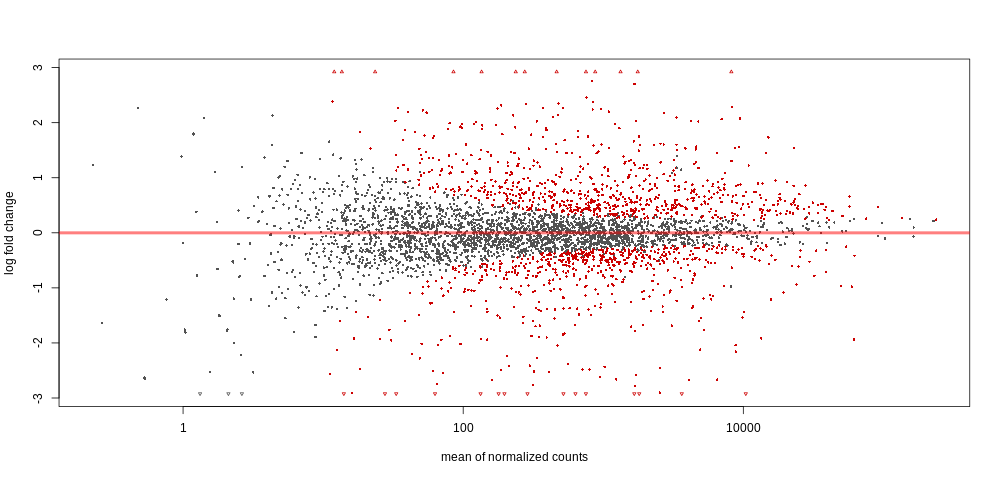

In [0]:
%%R -w 1000
plotMA(dds)

In [0]:
%%R
res <- results(dds)
head(results(dds))

log2 fold change (MLE): condition WT vs Mut 
Wald test p-value: condition WT vs Mut 
DataFrame with 6 rows and 6 columns
             baseMean     log2FoldChange             lfcSE              stat
            <numeric>          <numeric>         <numeric>         <numeric>
thrL 575.795898704587  -1.37102335857477 0.214538836308911 -6.39056024616753
thrA 54246.5866684502 -0.250839650706151 0.100139357567837 -2.50490573135769
thrB 12731.0321875407 -0.239402311220411 0.107735581418063 -2.22212854907628
thrC 19771.8873959734 -0.196043526896354 0.104959145875231 -1.86780794814583
yaaX 537.437545398481 -0.230291503275728 0.168280752666798 -1.36849580018051
yaaA 987.376008398115 -0.181734866893415   0.1305007220385 -1.39259663896572
                   pvalue                 padj
                <numeric>            <numeric>
thrL 1.65279068883245e-10 3.40406372440881e-09
thrA   0.0122484033691303   0.0419718994761146
thrB   0.0262746194089238   0.0796048873098111
thrC   0.0617888452008368   

In [0]:
%%R
summary(res)


out of 4136 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 755, 18%
LFC < 0 (down)     : 624, 15%
outliers [1]       : 0, 0%
low counts [2]     : 161, 3.9%
(mean count < 9)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [0]:
%%R
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): condition WT vs Mut 
Wald test p-value: condition WT vs Mut 
DataFrame with 6 rows and 6 columns
             baseMean    log2FoldChange             lfcSE              stat
            <numeric>         <numeric>         <numeric>         <numeric>
ompW 1763.13690709802   6.0943449429418 0.230306103457114  26.4619341452956
ubiA 2530.64840340984 -2.90207556985146 0.121821635126067 -23.8223330925435
rmf  6507.79447623627 -2.66569394138418  0.12323899209913 -21.6302802869401
nlpD 7003.37116657748  2.06335123856067 0.107836555155164  19.1340611316056
yahA  830.64691286902  2.75326954160719 0.158371599142959  17.3848692348043
hldD 8813.52832382799 -2.04038814035406 0.120247758696872 -16.9682010082001
                    pvalue                  padj
                 <numeric>             <numeric>
ompW 2.65967338974297e-154 1.05722017242283e-150
ubiA 1.96048202086495e-125  3.8964580164691e-122
rmf  9.32151739961112e-104 1.23510105544847e-100
nlpD  1.31425561901503e-81

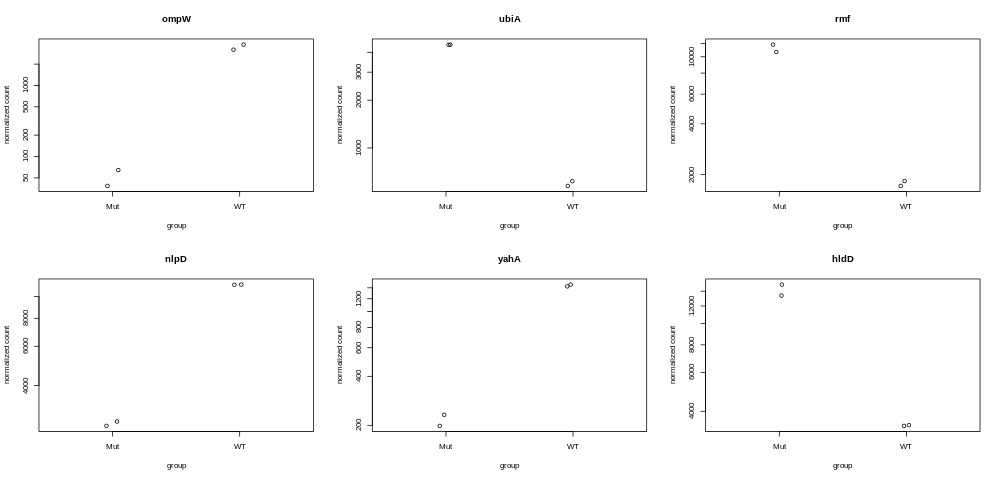

In [0]:
%%R -w 1000
par(mfrow=c(2,3))

plotCounts(dds, gene="ompW", intgroup="condition")
plotCounts(dds, gene="ubiA", intgroup="condition")
plotCounts(dds, gene="rmf", intgroup="condition")
plotCounts(dds, gene="nlpD", intgroup="condition")
plotCounts(dds, gene="yahA", intgroup="condition")
plotCounts(dds, gene="hldD", intgroup="condition")

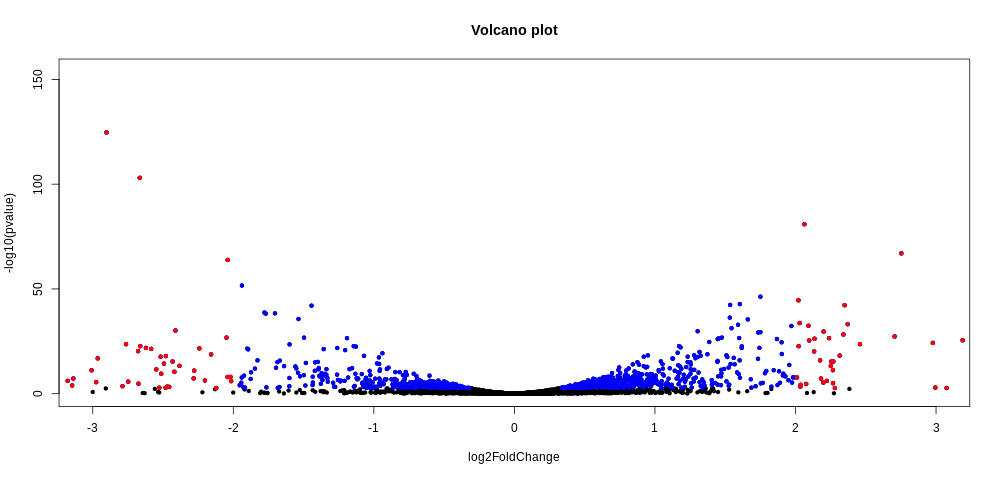

In [0]:
%%R -w 1000
par(mfrow=c(1,1))

with(res, plot(log2FoldChange, -log10(pvalue), pch=20, main="Volcano plot", xlim=c(-3,3)))

# Add colored points: blue if padj<0.01, red if log2FC>1 and padj<0.05)
with(subset(res, padj<.01 ), points(log2FoldChange, -log10(pvalue), pch=20, col="blue"))
with(subset(res, padj<.01 & abs(log2FoldChange)>2), points(log2FoldChange, -log10(pvalue), pch=20, col="red"))


## Задания

<b>Задание 1</b>. <i>Загрузите и обработайте оставшиеся образцы из статьи. Посмотрите на дифференциально экспрессированные гены в каждой из групп (по отношению к WT).<i>

<b>Задание 2</b>. <i>Постройте график PCA для всех получившихся точек и опишите его.</i>

<b>Задание 3</b>. <i>Изобразите теплокарту получившихся образцов. Какие именно гены вы выбрали для того, чтобы её построить?</i>

# Транскриптомика единичных клеток (scRNA-Seq)

В этой части мы посмотрим, как анализировать данные, полученные в результате scRNA-Seq. Важно понимать, что существует множество протоколов для single cell секвенирования. Здесь будет показано, как обрабатываются данные, полученные платформой <b>10x</b>. Их предобработка уже совершена (это происходит при помощи программы [CellRanger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) и требует достаточно больших вычислительных мощностей). В результате обработки CellRanger'ом у нас имеются три файла: <code>barcodes.tsv</code>, <code>matrix.mtx</code> и <code>genes.tsv<code>.

## Загрузка датасета и формат AnnData

In [0]:
!pip install scanpy leidenalg

In [0]:
!pip install scanpy[louvain]

In [0]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas.core.index import RangeIndex

sns.set_style("white")
mpl.rcParams["figure.dpi"] = 100

Считываем исследуемый датасет. Он состоит из трёх файлов &mdash;

1.   файл с матрицей;
2.   файл с баркодами, которые соответствуют клеткам;
3.   файл с ID генов и их названиями.

Все эти три файла хранятся в папке <code>10x_data</code>.

In [0]:
!wget kodomo.fbb.msu.ru/~s.isaev/10x_data.zip
!unzip 10x_data.zip

--2020-03-11 00:29:10--  http://kodomo.fbb.msu.ru/~s.isaev/10x_data.zip
Resolving kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)... 93.180.63.127
Connecting to kodomo.fbb.msu.ru (kodomo.fbb.msu.ru)|93.180.63.127|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15096051 (14M) [application/zip]
Saving to: ‘10x_data.zip’

10x_data.zip        100%[===================>]  14.40M  1.31MB/s    in 11s     

2020-03-11 00:29:23 (1.26 MB/s) - ‘10x_data.zip’ saved [15096051/15096051]

Archive:  10x_data.zip
   creating: 10x_data/
  inflating: 10x_data/barcodes.tsv   
  inflating: 10x_data/genes.tsv      
  inflating: 10x_data/matrix.mtx     


In [0]:
cell_names = pd.read_csv("10x_data/barcodes.tsv", names = ["Barcode"])
gene_names = pd.read_csv("10x_data/genes.tsv", names = ["ID", "Gene"], sep = "\t")
adata = sc.read("10x_data/matrix.mtx").transpose()
adata.var_names = gene_names["Gene"]
adata.obs.index = list(cell_names["Barcode"])
print(adata)

AnnData object with n_obs × n_vars = 64153 × 44792 


Теперь у нас есть переменная типа AnnData. Подробнее об этом формате можно прочитать <a href="https://icb-anndata.readthedocs-hosted.com/en/stable/index.html" target="_blank">тут</a>. Если кратко, то центром этого типа данных является наша матрица экспрессий <code>adata.X</code>. У нас она хранится в <a href="https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D0%B7%D1%80%D0%B5%D0%B6%D0%B5%D0%BD%D0%BD%D0%B0%D1%8F_%D0%BC%D0%B0%D1%82%D1%80%D0%B8%D1%86%D0%B0" target="_blank">sparse-виде</a>, и просто так на её содержимое не посмотреть &mdash; придётся конвертировать явно (в принципе нам это и не потребуется).

In [0]:
adata.X

<64153x44792 sparse matrix of type '<class 'numpy.float32'>'
	with 4417487 stored elements in Compressed Sparse Row format>

Эта матрица в нашем случае имеет разрешение 64 153 на 44 792. То есть мы имеем 64 тысячи клеток с информацией об экспрессии 44 тысяч генов. Представим, что наши клетки &mdash; это строки, а гены &mdash; столбцы. Тогда каждой строке соответствует, в первую очередь, определённый баркод (UMI), которому эта клетка соответствует. Также каждой клетке может соответствовать дополнительная информация &mdash; её характеристики качества, тип клетки и проч. И всё это будет храниться в формате DataFrame с размерностью <code>число клеток</code> * <code>число любых характеристик, которые только можно придумать</code>. Однако сейчас ничего из этого нам не известно, только баркоды. Содержание мета-информации по клеткам можно посмотреть, вызвав <code>adata.obs</code>.

In [0]:
adata.obs

""
TCCATGCCAGAAGCTG-1
TCCTCTTGGCCAAGGT-1
TGAGCGCAGCACTCGC-1
GTAGAGGGTTCAAAGA-1
CCTCATCAGTCCCGAC-1
...
GAAAGCTGTCTGTTAG-1
GCTACAATCACCGGGT-1
CTGTCTGTCAGTTTGG-1
GTGCTTCTCCCAAGTA-1


Соответственно, похожая история актуальна и для характеристик по генам &mdash; в первую очередь, их названия. Какие ещё можно придумать поля, характеризующие гены? Например, число клеток, в которых экспрессируется конкретный ген, их встречаемость в рахных тканях и проч. Вызвать можно при помощи <code>adata.var</code>.

In [0]:
adata.var

""
Gene
AC000032.2
NUCB2
RP11-206M11.7
RP5-940J5.6
RP11-386M24.6
...
RP11-946P6.4
RP11-466I1.1
ZUFSP


Кратко суммируя выше сказанное, итоговая переменная <code>adata</code>, с которой вы будете работать, выглядит следующим образом:<br>
<center><img src="https://falexwolf.de/img/scanpy/anndata.svg" align="center" width="600px"></center><br>

## Контроль качества

Сейчас мы проведём базовый контроль качества <b>клеток</b> (а не прочтений! Прочтения уже позади) при помощи встроенных функций scanpy.

In [0]:
sc.pp.calculate_qc_metrics(adata, inplace = True)
print(adata)

AnnData object with n_obs × n_vars = 64153 × 44792 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


Мы видим, что уже тут появилось очень много дополнительной информации как про гены, так и про клетки. Давайте посмотрим, что теперь у нас лежит в датафрейме <code>adata.obs</code>.

In [0]:
adata.obs.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes
TCCATGCCAGAAGCTG-1,10,2.397895,10.0,2.397895,100.0,100.0,100.0,100.0
TCCTCTTGGCCAAGGT-1,10,2.397895,10.0,2.397895,100.0,100.0,100.0,100.0
TGAGCGCAGCACTCGC-1,11,2.484907,13.0,2.639057,100.0,100.0,100.0,100.0
GTAGAGGGTTCAAAGA-1,9,2.302585,9.0,2.302585,100.0,100.0,100.0,100.0
CCTCATCAGTCCCGAC-1,19,2.995732,19.0,2.995732,100.0,100.0,100.0,100.0


Нас интересуют не все поля, остановим внимание только на некоторых:
<ol>
    <li><code>total_genes_by_counts</code>: количество различных генов, экспрессия которых была детектирована в клетке;</li>
    <li><code>total_counts</code>: количество уникальных UMI (= транскриптов, молекул РНК), которые удалось обнаружить в этой клетке.</li>
</ol>
И тут мы переходим к интересному &mdash; можно посмотреть, сколько же РНК мы обнаружили в отсеквенированных клетках.

(0, 10000)

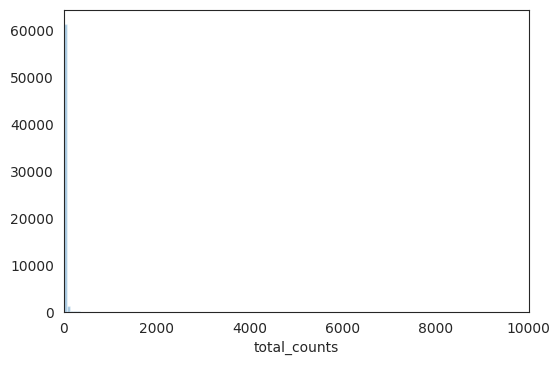

In [0]:
ax = sns.distplot(adata.obs["total_counts"], hist = True, bins = 1000, kde = False)
ax.set_xlim(0, 10000)

Видно, что не всё так радужно &mdash; у нас достаточно много просто пустых клеток, а также клеток, у которых всего несколько транскриптов. Давайте их отфильтруем и поставим условную границу в, например, 100 транскриптов. Посмотрим, что станет.

(0, 10000)

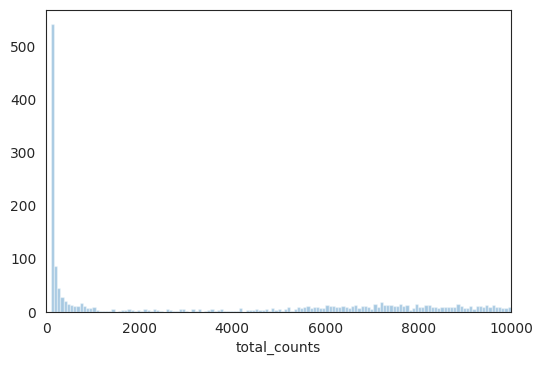

In [0]:
adata = adata[adata.obs["total_counts"] > 100, :]
ax = sns.distplot(adata.obs["total_counts"], hist = True, bins = 1000, kde = False)
ax.set_xlim(0, 10000)

Тут всё выглядит лучше, но теперь давайте построим этот график в логарифмической шкале и посмотрим чуть правее.

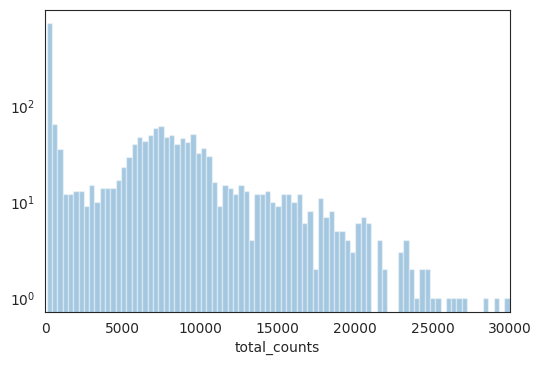

In [0]:
ax = sns.distplot(adata.obs["total_counts"], hist = True, bins = 200, kde = False)
ax.set_xlim(0, 30000)
ax.set_yscale("log")

Видно, что в районе 7 тысяч транскриптом имеется некоторый пик. Будем считать этот пик биологически значимым, а всё, что имеет меньше 2500 транскриптов &mdash; шумом. Также нас должен смущать избыток транскриптов &mdash; это может говорить о дублетах.

(2500, 17000)

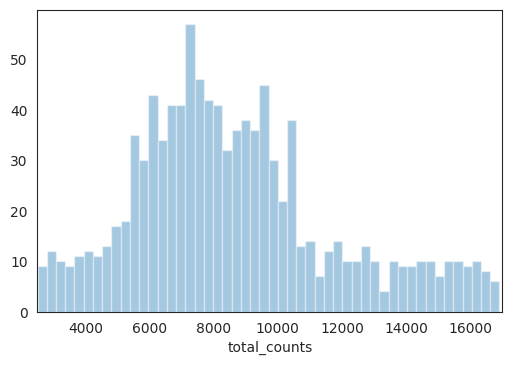

In [0]:
adata = adata[adata.obs["total_counts"] > 2500, :]
adata = adata[adata.obs["total_counts"] < 17000, :]

ax = sns.distplot(adata.obs["total_counts"], hist = True, bins = 50, kde = False)
ax.set_xlim(2500, 17000)

Отлично! И сколько же у нас в итоге осталось клеток?

In [0]:
print(adata)

View of AnnData object with n_obs × n_vars = 1024 × 44792 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


Всего около тысячи из шестидесяти тысяч(!) клеток прошли контроль качества. Если бы мы его не провели и выполнили анализ дальше, мы бы просто ничего не увидели за шумом.

Ещё одной хорошей метрикой контроля качества является процент митохондриальной экспрессии в клетках. Принято фильтровать те клетки, у которых митохондриалки больше 15%.

In [0]:
mito_genes = adata.var_names.str.startswith("MT-")
adata.obs["percent_mito"] = np.sum(adata[:, mito_genes].X, axis = 1) / np.sum(adata.X, axis = 1)
adata = adata[adata.obs["percent_mito"] < 0.15, :]

Trying to set attribute `.obs` of view, copying.


В итоге дальше мы будем работать со следующим датасетом:

In [0]:
print(adata)

View of AnnData object with n_obs × n_vars = 938 × 44792 
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


## Подготовка к анализу и кластеризация

Из-за того, что разные клетки в нашем датасете несут в себе разное количество молекул РНК, и очень часто это просто технический шум, а не биологическая особенность, нам необходимо нормировать количество РНК внутри каждой клетки.

In [0]:
sc.pp.normalize_total(adata, target_sum = 1e6)
print(adata.X.sum(axis = 1)[:5])

[[ 999999.94]
 [1000000.  ]
 [ 999999.94]
 [ 999999.94]
 [ 999999.94]]


Видно, что везде в итоге мы имеем сумму в виде 1 000 000. Эта метрика называется CPM (по аналогии с TPM). Как было сказано на занятии по анализу bulk RNA-seq, эта метрика часто не подходит для многих типов анализа, однако <a href="https://towardsdatascience.com/how-to-normalize-single-cell-a438281ea654" target="_blank">было показано</a>, что в целом практически любая нормализация (именно в контексте single cell RNA-seq) несильно смещает результаты анализа, а выбранная нами интуитивнее всего.

Следующей важной стадией является логарифмирование экспрессий для дальнейшего анализа.

In [0]:
sc.pp.log1p(adata)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


А теперь важный момент &mdash; <b>выбор генов, которые будут использоваться для того, чтобы снижать размерность данных</b> (feature selection). История тут следующая: очень много генов имеют одинаковую экспрессию, это не даёт нам никакой информации. Хочется для построения графиков снижения размерности (PCA / UMAP / t-SNE) использовать минимальное число переменных (чем выше размерность, тем хуже с ней работать), но обладающих наибольшей информацией. Для этого специально выбирают гены с высокой дисперсией по экспрессии. Сравните, что будет в случае, когда их выбирают и когда их не выбирают.

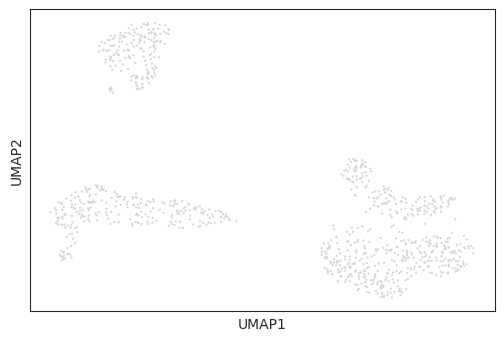

In [0]:
#Без выбора HVG

sc.tl.pca(adata, svd_solver = "arpack")
sc.pp.neighbors(adata, n_neighbors = 40, n_pcs = 15)
sc.tl.umap(adata)
sc.pl.umap(adata, size = 10)

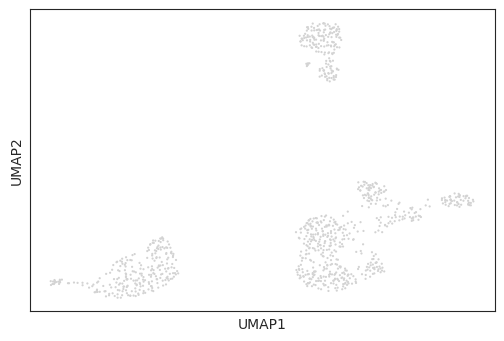

In [0]:
#С выбором HVG

adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes = 3000)
sc.tl.pca(adata, svd_solver = "arpack")
sc.pp.neighbors(adata, n_neighbors = 40, n_pcs = 15)
sc.tl.umap(adata)
sc.pl.umap(adata, size = 10)

Во втором случае у нас визуально выделилось больше кластеров. В случае с датасетом, который мы обрабатываем, в целом выделение высоко-вариабельных генов не сильно улучшило историю, потому что данные хорошие и клетки сильно отличаются по экспрессиям, однако в более тяжёоых случаях выделение набора HVG (высоко вариабельных генов) просто необходимо для качественного анализа. Также легко заметить, что работа с поднабором HVG просто ощутимо быстрее, чем без, поэтому для датасетов с сильно большим числом клеток все гены не используют.

Теперь разберём код, написанный выше.
В строке <code>adata.raw = adata</code> мы зафиксировали слой raw, в котором будут храниться сырые логарифмированные экспрессии всех генов (не только HVG) &mdash; для анализа дифф. экспрессий, например. Для новых версий пакета <code>scanpy</code> это не совсем актуально, но на всякий случай можно перестраховаться. Также перед тем, как снижать дальше размерность, необходимо найти главные компоненты пространства и снизить размерность сначала именно при помощи метода PCA &mdash; даже 3000-мерное пространство слишком большое и трудное для UMAP или tSNE. В итоге в строке <code>sc.pp.neighbors(adata, n_neighbors = 40, n_pcs = 15)</code> мы ищем соседей для каждой точки (клетки) &mdash; это необходимо перед использованием UMAP или tSNE. В целом про tSNE можно хорошо прочитать <a href="https://m.habr.com/ru/post/267041/" target="_blank">про t-SNE</a> и <a href="https://github.com/lmcinnes/umap" target="_blank">про UMAP</a> можно по ссылкам.

Теперь мы проведём кластеризацию при помощи метода leiden (впервые использовался <a href="https://arxiv.org/abs/1810.08473" target="_blank">тут</a>).

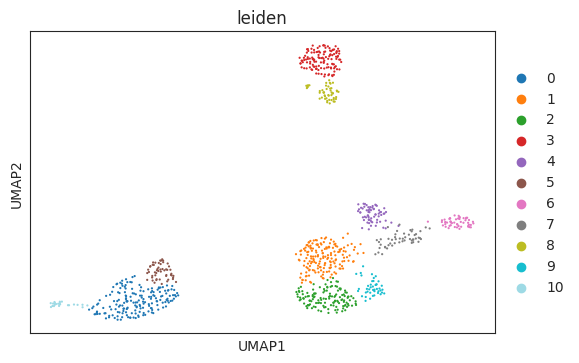

In [0]:
sc.tl.leiden(adata)
sc.pl.umap(adata, size = 10, color = "leiden", palette = "tab20")

Также есть другой метод кластеризации &mdash; при помощи алгоритма <code>louvain</code> (также имплементирован в scanpy).

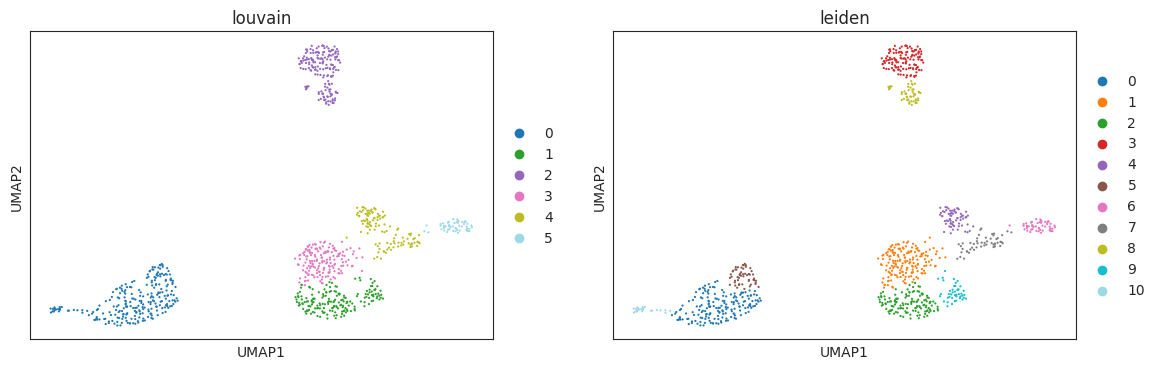

In [0]:
sc.tl.louvain(adata)
sc.pl.umap(adata, size = 10, color = ["louvain", "leiden"], palette = "tab20")

Визуально алгоритм <code>leiden</code> более интуитивно разделяет кластеры, поэтому выберем его. 

Посмотрим на дифференциально экспрессированные гены между кластерами, чтобы понять, с чем мы вообще имеем дело. Статистический метод определение дифференциальной экспрессии выберем ранговый &mdash; Вилкоксон.

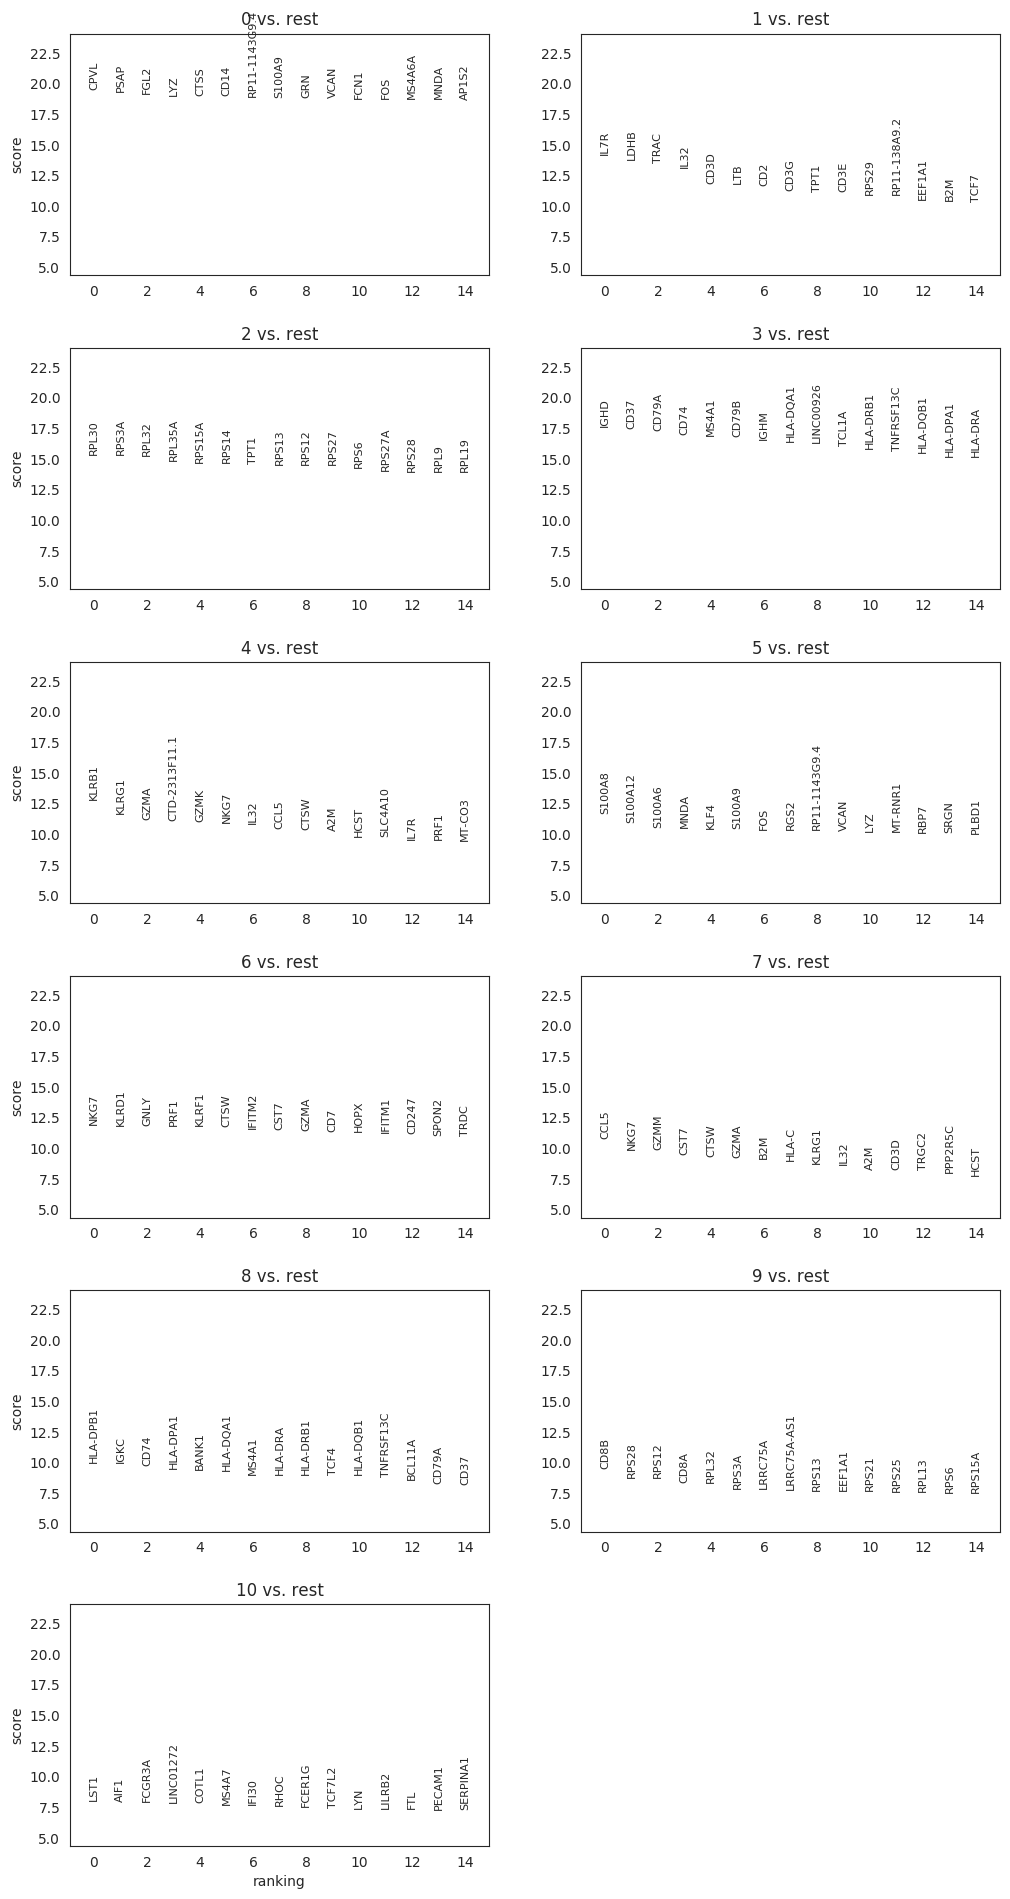

In [0]:
sc.tl.rank_genes_groups(adata, "leiden", method = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes = 15, ncols = 2)

Теперь выберем метод с использованием логистической регрессии (<a href="https://www.biorxiv.org/content/10.1101/258566v2" target="_blank">ссылка</a>) &mdash; это уже больше похоже на генерализованные линейные модели, используемые в edgeR и DESeq2 для bulk RNA-Seq.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


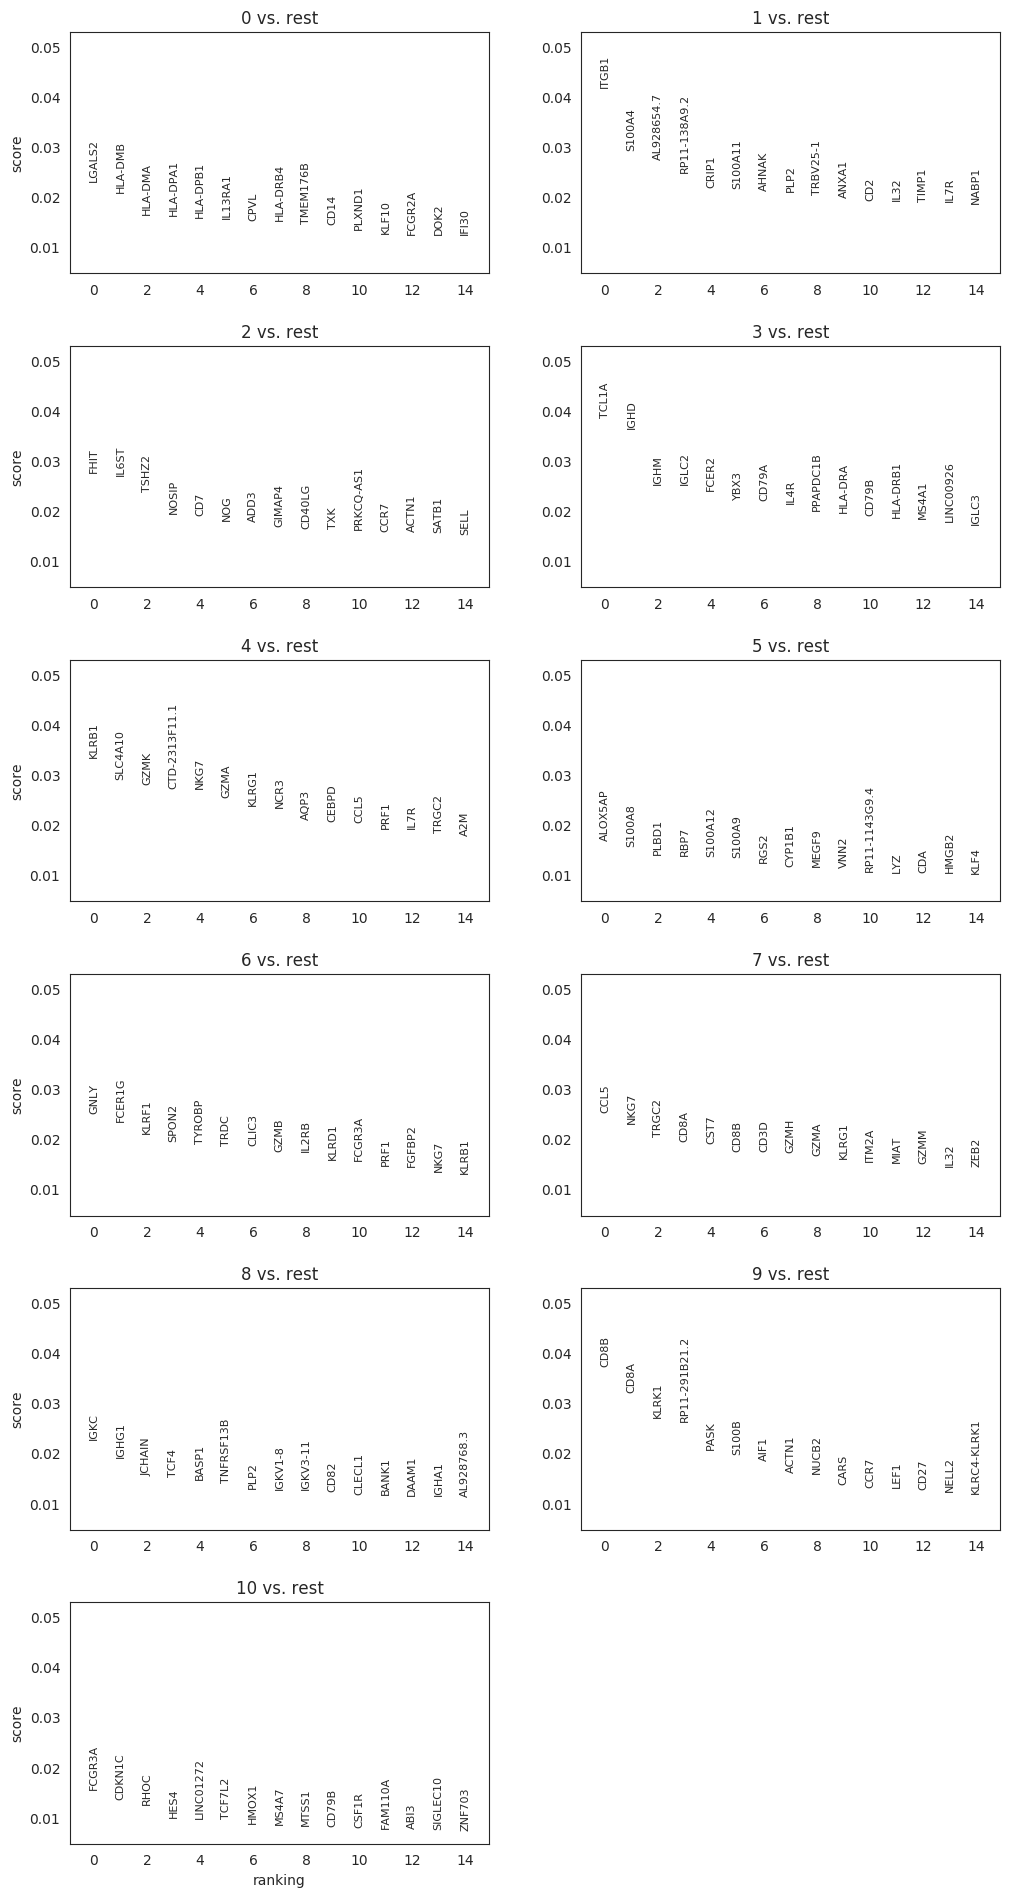

In [0]:
sc.tl.rank_genes_groups(adata, "leiden", method = "logreg")
sc.pl.rank_genes_groups(adata, n_genes = 15, ncols = 2)

И теперь уже исходя из дифференциально экспрессированных генов и литературной информации (много, много статей) можно предположить, что значит каждый кластер в биологическом смысле. Сам набор генов (много генов кластеров дифференциации и проч.) подсказывает, что перед нами клетки крови. А именно, если раскрыть карты, scRNA-seq PBMC.

Теперь нас ждёт работа с литературными данными, и необходимо определить, какие маркерные гены где экспрессированы. Можно обратить внимание, что дифференциальная экспрессия смотрелась между группами <code>конкретный кластер</code> vs. <code>всё остальное</code>, однако в случае, когда нам важно определить субпопуляции клеток, можно воспользоваться точечным сравнением двух групп. Но для начала можно просто посмотреть на известные маркёры разных популяций клеток крови и прикинуть, что перед нами (например, посмотреть их в <a href="https://www.proteinatlas.org/" target="_blank">Protein Atlas</a>).

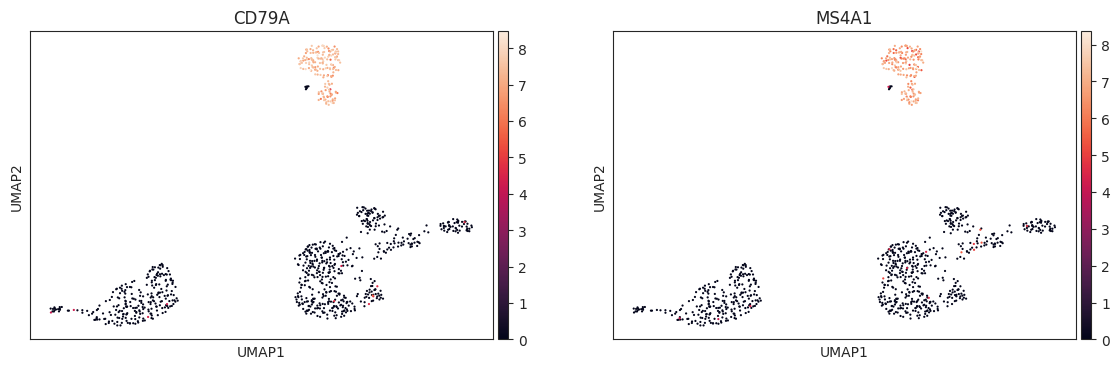

In [0]:
sc.pl.umap(adata, size = 10, color = ["CD79A", "MS4A1"], palette = "tab20") #B-клетки

## Задания

<b>Задание 1</b>. <i>Завершить анализ полученных кластеров и определить, какие клеточные типы представлены в полученном датасете. В процессе аннотации используйте Gene Ontology.</i>

<b>Задание 2</b>. <i>Попробуйте оценить, в какой фазе клеточного цикла находится каждая из клеток. Возможно ли при кластеризации учесть этот фактор, чтобы он не вносил дополнительный фактор, мешающий определению типов клеток?</i>